### НИЯУ МИФИ. Лаботаторная работа #2. Полищук Максим, Б20-505

# Используемая система

```
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  6
  On-line CPU(s) list:   0-5
Vendor ID:               GenuineIntel
  Model name:            12th Gen Intel(R) Core(TM) i5-12400F
```

## Оценка сложности
- Лучший случай: O(1)
- Худший случай: O(n)
- Средний случай: O(n)



```mermaid
    %%{ init : {"flowchart" : { "curve" : "stepAfter", "diagramPadding" : 20 }}}%%
    graph LR
        A(Начало) --> B(i: 0 -> n)
        
        B --> C{"array[i] == target"}
        C -->|Да| D["index = i"]
        D --> E(выход)
        C -->|Нет| B
```

# Код
```
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define STEP 10000

int main(int argc, char** argv)
{
    const int count = 10000000;     ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed
    // const int target = 16;          ///< Number to look for

    int* array = 0;                 ///< The array we need to find the max in
    int  index = -1;                ///< The index of the element we need

    /* Initialize the RNG */
    srand(random_seed);
    double start, end;

    /* Generate the random array */
    array = (int*)malloc(count*sizeof(int));
    for(int i=0; i<count; i++) { array[i] = rand(); }

    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }
    int threads = omp_get_max_threads();
    // printf("THREADS - %d", threads);
    // exit(1);

    for (int thread = 1; thread <= threads; thread++) {

        for (int ind = 0; ind < count; ind += STEP) {
            int target = array[ind];
            int ans = count;
            int tmp = count;
            start = omp_get_wtime();
            #pragma omp parallel num_threads(thread) shared(array, tmp, target) reduction(min: ans) default(none)
            {
                #pragma omp for
                for(int i=0; i<tmp; i++)
                {
                    if(array[i] == target) { 
                        ans = i;
                        tmp = 0;
                    };
                }
            }
            end = omp_get_wtime();
            if (ind != count - STEP) {
                fprintf(fp, "%f;", end-start);
            } else {
                fprintf(fp, "%f\n", end-start);
            }
            printf("Found occurence of %d at index %d;\n", target, ans);
        }
    }
    fclose(fp);
    printf("Exit...\n");
    return(0);
}
```

In [16]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

dataset = []
with open("trace.txt", "r") as f:
    for _ in range(12):
        line = list(map(float, f.readline().split(";")))
        dataset.append(line)
        
for i in range(len(dataset)):
    line = dataset[i]
    line.sort()
    line = line[10:-10]
    dataset[i] = line

sns.set(rc={'figure.figsize':(12,8)})

In [17]:
data = []
for i, line in enumerate(dataset):
    data.append([i+1, (sum(line)/len(line))*1000, "Real"])
saved = data.copy()
data1 = data
data_df = pd.DataFrame(data, columns=["Threads", "AvgTime", "Type"])
for i in range(1, len(data1)): 
    data1[i] = [data1[i][0], data1[0][1] / data1[i][0], "Perfect"]
data1[0][2] = "Perfect"
# pdf = pd.DataFrame(data1, columns=["Threads", "AvgTime"])
data1 = pd.DataFrame(data1, columns=["Threads", "AvgTime", "Type"])
all_data = pd.concat([data1, data_df])

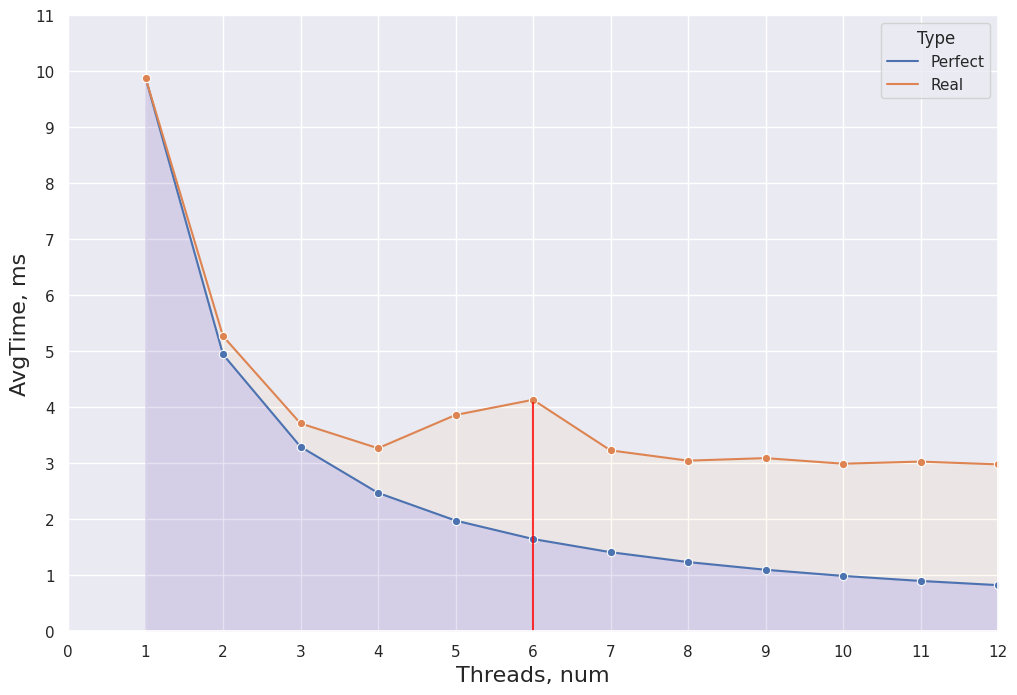

In [28]:
p = sns.lineplot(x="Threads", y="AvgTime", hue="Type", marker="o", data=all_data)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("AvgTime, ms", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

p.fill_between(x1, y1, color="blue", alpha=0.1)
l2 = p.lines[1]

x2 = l2.get_xydata()[:, 0]
y2 = l2.get_xydata()[:, 1]

p.fill_between(x2, y2, color="orange", alpha=0.05)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, 13))
_ = p.set_xticklabels(str(i) for i in range(0, 13))
_ = p.set_yticks(range(0, 12))
_ = p.set_yticklabels([str(i) for i in range(0, 12)])
_ = p.axvline(x=6, ymax=0.37, color="red", alpha=0.8)

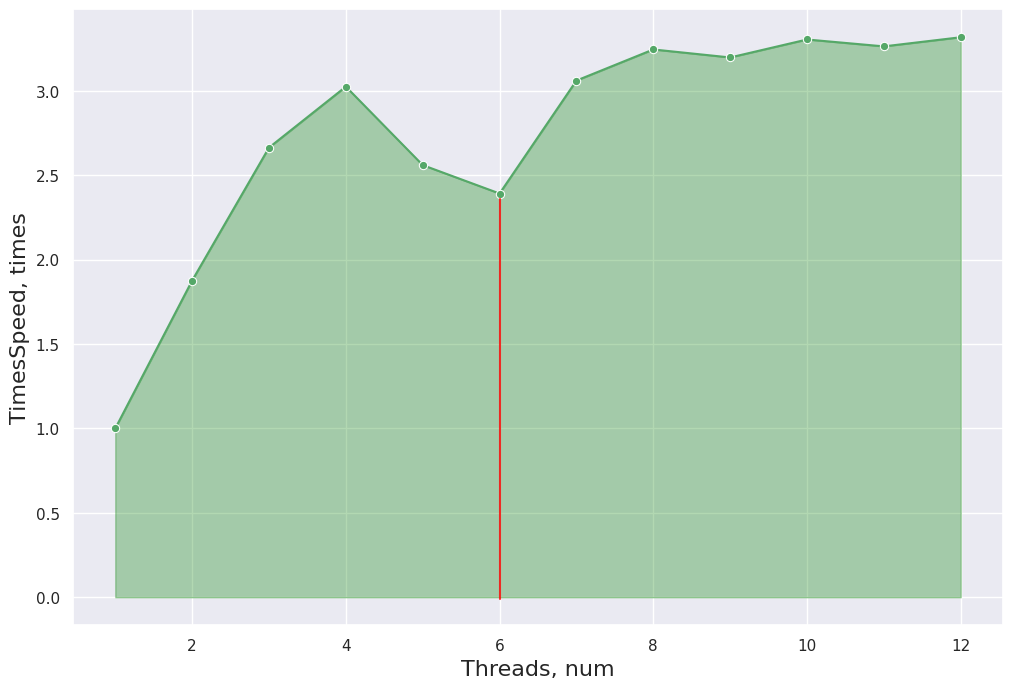

In [42]:
accceleration = [0] * 12
for i in range(0, len(accceleration)):
    accceleration[i] = [saved[i][0], saved[0][1]/saved[i][1]]
a_df = pd.DataFrame(accceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='g')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="green", alpha=0.3)
_ = p.axvline(x=6, ymin=0.043 ,ymax=0.692, color="red", alpha=0.8)

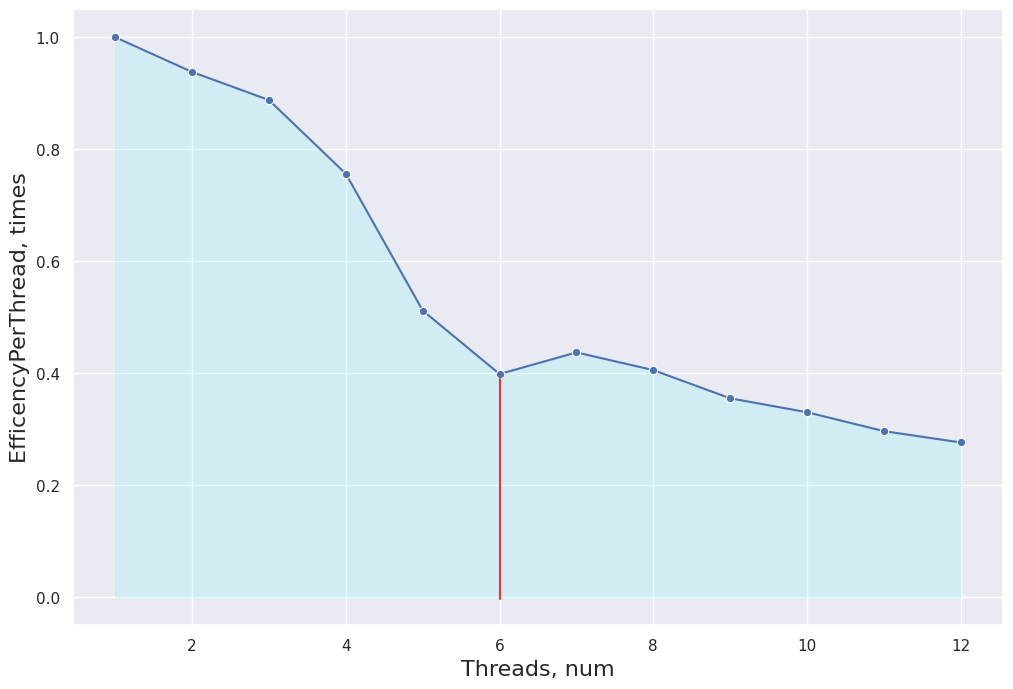

In [43]:
per_thread = [0] * 12
for i in range(0, len(per_thread)):
    per_thread[i] = [accceleration[i][0], accceleration[i][1]/accceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='b')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.axvline(x=6, ymin=0.043 ,ymax=0.4, color="red", alpha=0.8)

## Заключение
В данной работе я ознакомился с параллельными циклами, в том числе узнал о некоторых проблемах составления параллельных алгоритмов. 
- Создание виртуальных потоков может не то что не изменить производительность, но и ухудшить её
- Использование (почти) всех доступных потоков системы может негативно сказаться на производительности т.к. минимум один поток будет всегда занят фоновыми процессами ОС (тот же Discord к примеру), из-за чего увеличиться время ответа.
- Возможны случаи, когда ответ будет неверен в случае. 

#### Случай ошибки вычислений
Имеется массив ``[1, 2, 3, 3, 2, 1, 3, 0, 0]``, задача - найти индекс тройки. В случае выделения трёх потоков каждый будет работать с интервалами по 3 элемента и каждый найдёт нужный элемент, только после этого выйдя из цикла. Т.к. используется директива ``reduction(max: ans)``, то программа вернёт индекс последней тройки, что не является верным ответом. => **необходимо использовать reduction(min)**, перед этим задав ans = len(arr)